# Fake News Detection: Data Exploration & Final Model Analysis

**Author:** Sahil Khan

This notebook provides a detailed walkthrough of the data processing, exploratory data analysis (EDA), and a visual comparison of the final model results for the Fake News Detection project.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

sns.set_theme(style='whitegrid', palette='viridis')
plt.rcParams['figure.figsize'] = (14, 7)

# Load final results
RESULTS_PATH = '../results/model_comparison.json'
DISTILBERT_STATS_PATH = '../results/transformer_distilbert_training_stats.json'
ALBERT_STATS_PATH = '../results/transformer_albert_training_stats.json'

with open(RESULTS_PATH, 'r') as f:
    results = json.load(f)
with open(DISTILBERT_STATS_PATH, 'r') as f:
    distilbert_stats = json.load(f)
with open(ALBERT_STATS_PATH, 'r') as f:
    albert_stats = json.load(f)

## 1. Final Model Performance

First, we'll parse the final evaluation results into a DataFrame for easy visualization.

In [4]:
results_list = []
for model_name, data in results.items():
    entry = {
        'model': model_name,
        'f1_score': data['performance']['f1_score'],
        'accuracy': data['performance']['accuracy'],
        'inference_ms': data['resources']['avg_inference_ms'],
        'memory_mb': data['resources']['memory_mb']
    }
    results_list.append(entry)

results_df = pd.DataFrame(results_list).sort_values(by='f1_score', ascending=False)
display(results_df)

,model,f1_score,accuracy,inference_ms,memory_mb
3,distilbert,0.931021,0.924912,7.0807,141.36
4,albert,0.929387,0.924290,20.6612,16.12
2,svm,0.914107,0.908940,0.1901,407.47
0,logistic_regression,0.911343,0.906451,0.2870,415.50
1,naive_bayes,0.881215,0.875130,0.2043,409.28


### 1.1. Core Performance Metrics (F1-Score)

C:\Users\Sahil Khan\AppData\Local\Temp\ipykernel_44836\2363725200.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='f1_score', y='model', data=results_df, palette='viridis')


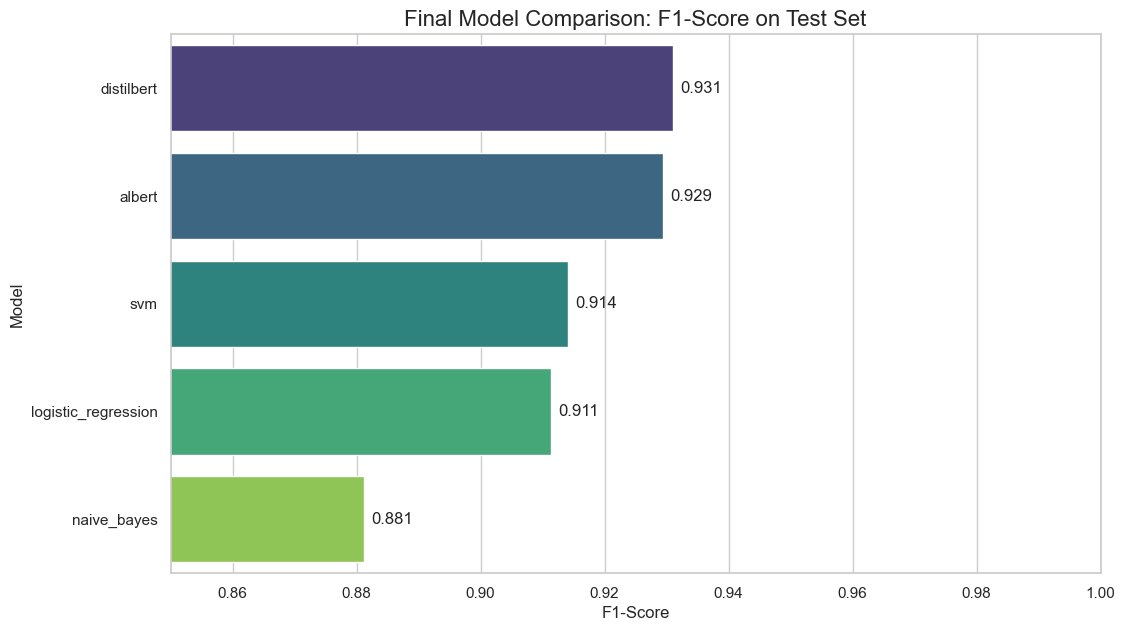

In [5]:
plt.figure(figsize=(12, 7))
ax = sns.barplot(x='f1_score', y='model', data=results_df, palette='viridis')
plt.title('Final Model Comparison: F1-Score on Test Set', fontsize=16)
plt.xlabel('F1-Score', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xlim(0.85, 1.0)
for p in ax.patches:
    ax.annotate(f'{p.get_width():.3f}', (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', xytext=(5, 0), textcoords='offset points')
plt.show()

**Insight:** The transformer models, DistilBERT and ALBERT, clearly outperform the traditional machine learning models, with DistilBERT achieving the highest F1-Score.

### 1.2. The Accuracy vs. Resource Trade-Off

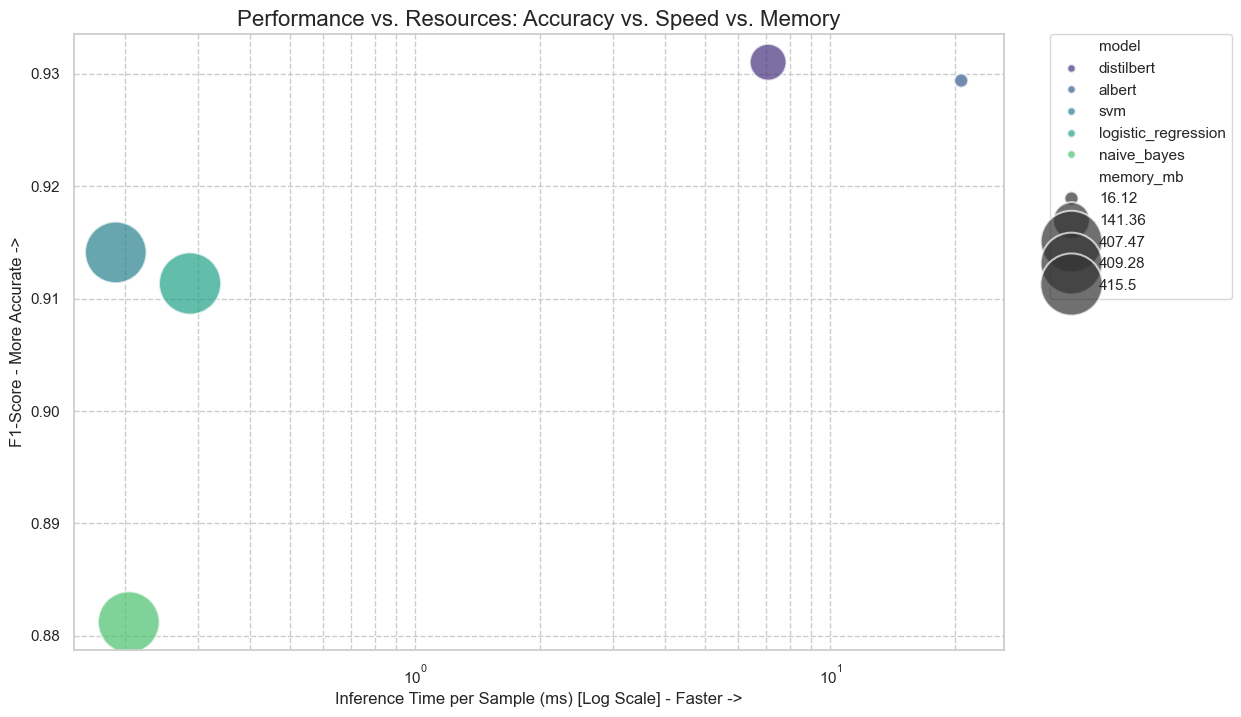

In [6]:
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(
    data=results_df,
    x='inference_ms',
    y='f1_score',
    size='memory_mb',
    hue='model',
    sizes=(100, 2000),
    alpha=0.7
)
ax.set_xscale('log')
plt.title('Performance vs. Resources: Accuracy vs. Speed vs. Memory', fontsize=16)
plt.xlabel('Inference Time per Sample (ms) [Log Scale] - Faster ->', fontsize=12)
plt.ylabel('F1-Score - More Accurate ->', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True, which="both", ls="--")
plt.show()

**Insight:** This chart tells the complete story. 
* **Bottom-Left:** Traditional models are extremely fast but less accurate.
* **Top-Right:** Transformers offer the highest accuracy. While DistilBERT is faster, ALBERT is a clear winner in memory efficiency (represented by the small bubble size), making it a fantastic choice for memory-constrained environments.

### 1.3. Confusion Matrix Analysis

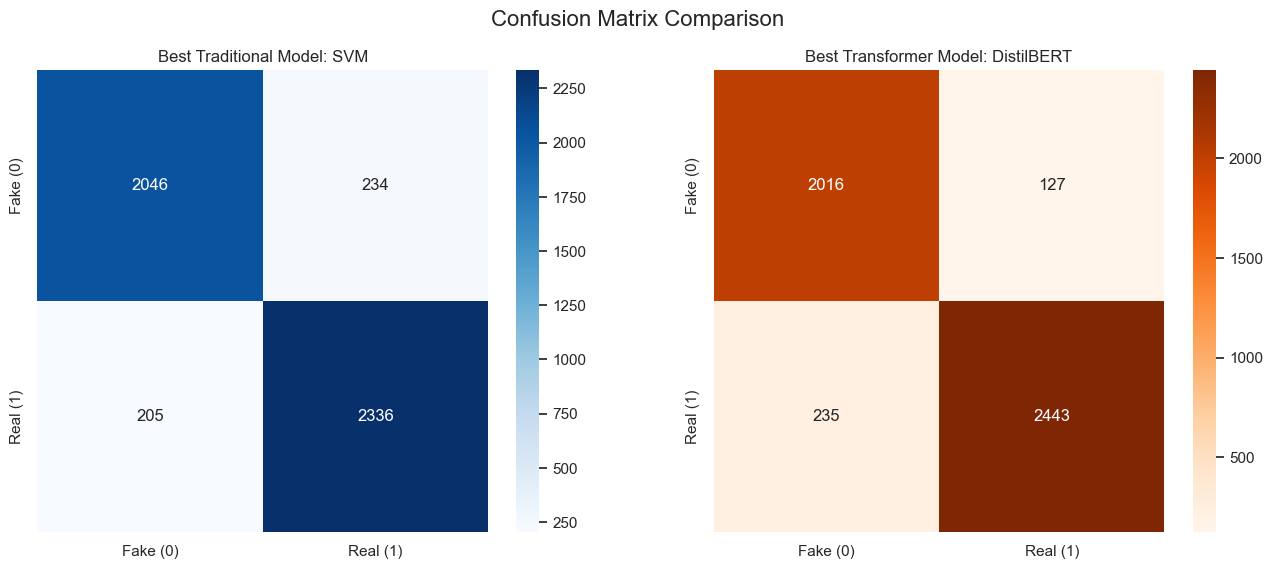

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Confusion Matrix Comparison', fontsize=16)

cm_svm = results['svm']['performance']['confusion_matrix']['matrix']
cm_labels = results['svm']['performance']['confusion_matrix']['labels']
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', ax=axes[0], xticklabels=cm_labels, yticklabels=cm_labels)
axes[0].set_title('Best Traditional Model: SVM')

cm_distilbert = results['distilbert']['performance']['confusion_matrix']['matrix']
sns.heatmap(cm_distilbert, annot=True, fmt='d', cmap='Oranges', ax=axes[1], xticklabels=cm_labels, yticklabels=cm_labels)
axes[1].set_title('Best Transformer Model: DistilBERT')

plt.show()

**Insight:** DistilBERT made fewer errors overall, particularly in reducing the number of False Positives (Real news classified as Fake) and False Negatives (Fake news classified as Real) compared to SVM.

## 2. Transformer Training Analysis

Let's analyze the training process for our transformer models by plotting their training and validation loss over epochs. This helps us understand if the models learned effectively and didn't overfit.

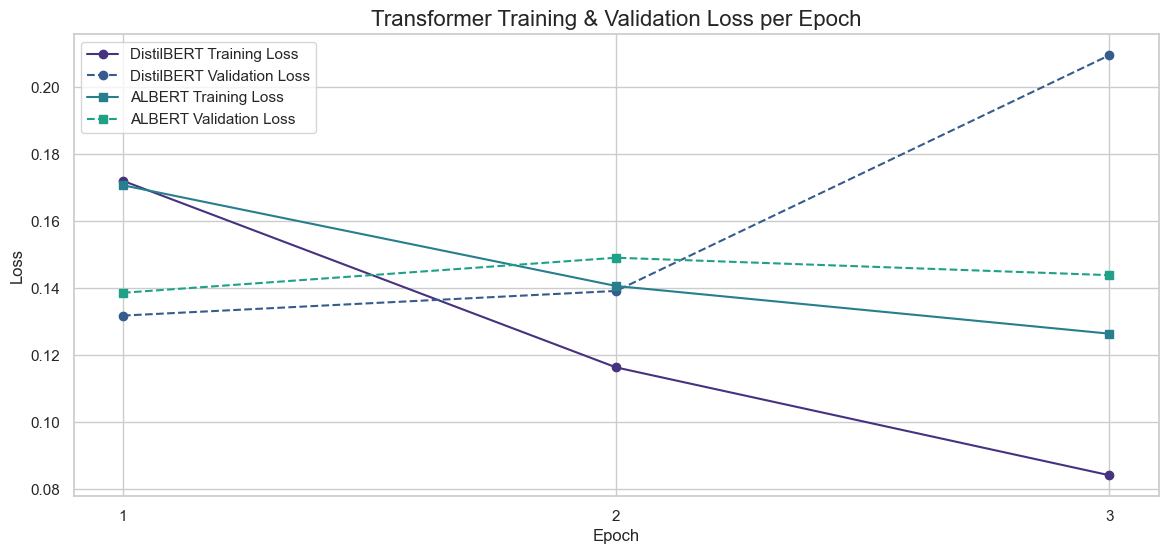

In [8]:
distilbert_df = pd.DataFrame(distilbert_stats)
albert_df = pd.DataFrame(albert_stats)

plt.figure(figsize=(14, 6))
plt.plot(distilbert_df['epoch'], distilbert_df['training_loss'], 'o-', label='DistilBERT Training Loss')
plt.plot(distilbert_df['epoch'], distilbert_df['validation_loss'], 'o--', label='DistilBERT Validation Loss')
plt.plot(albert_df['epoch'], albert_df['training_loss'], 's-', label='ALBERT Training Loss')
plt.plot(albert_df['epoch'], albert_df['validation_loss'], 's--', label='ALBERT Validation Loss')

plt.title('Transformer Training & Validation Loss per Epoch', fontsize=16)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks([1, 2, 3])
plt.legend()
plt.grid(True)
plt.show()

**Insight:** Both models show a healthy learning curve. The training loss consistently decreases, while the validation loss remains low, indicating that the models learned to generalize well to new data without significant overfitting.